In [1]:
import pandas as pd
import matplotlib as mpl

mpl.rcParams['animation.embed_limit'] = 100  # в МБ

In [2]:
%matplotlib inline

In [3]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from tqdm import tqdm
import matplotlib.pyplot as plt


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from IPython.display import HTML


# **Вариант A: Система временной стабилизации масок (anti-flicker)**

### **Задание**

1. Выбрать любой ролик с движущимся объектом.
   Допускается использование пользовательского видео или произвольного доступного датасета.

2. Прогнать видеоряд через любую **предобученную модель сегментации по кадрам** (Mask R-CNN, Mask2Former, DeepLabv3 или другая), получив последовательность бинарных масок.

3. Реализовать систему **оценки временной нестабильности** масок:
   измерить покадровую разницу, например через IoU соседних масок, либо метрику «маска меняется там, где объект не менялся».

4. Реализовать **сглаживание масок во времени** одним из методов:
   – сглаживание вероятностных карт (усреднение окна по времени);
   – медианное сглаживание по последовательности масок;
   – сглаживание с весами, зависящими от величины локального движения.

5. Построить итоговые маски после сглаживания.

6. Сравнить качество «до/после» через собственные визуализации и метрики нестабильности.

7. Подготовить короткое описание инженерного решения:
   почему выбран именно этот метод, какие параметры оказались чувствительными, где сглаживание помогает, а где ухудшает сегментацию.


In [5]:
VIDEO_PATH = r'C:\\Users\\kuzin\\.cache\\huggingface\\hub\\datasets--nateraw--kinetics-mini\\snapshots\\9f4ed38128a355c352527209101be3e326471816\\train\\bowling\\-5ExwuF5IUI_000030_000040.mp4'

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TARGET_CLASS = 1   # COCO: 1 = person
SCORE_THRESH = 0.5
MASK_THRESH = 0.5

TEMPORAL_WINDOW = 2   # k → окно = 2k + 1

In [7]:
model = maskrcnn_resnet50_fpn(pretrained=True)
model.to(DEVICE)
model.eval()

transform = transforms.Compose([
    transforms.ToTensor()
])

C:\Users\kuzin\PycharmProjects\VideoStreaming\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kuzin\PycharmProjects\VideoStreaming\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def read_video(path):
    cap = cv2.VideoCapture(path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()
    return frames

In [9]:
frames = read_video(VIDEO_PATH)
print(f"Loaded {len(frames)} frames")


Loaded 300 frames


In [10]:
@torch.no_grad()
def segment_frames(frames):
    prob_maps = []
    bin_masks = []

    for frame in tqdm(frames, desc="Segmenting"):
        x = transform(frame).to(DEVICE)
        output = model([x])[0]

        mask = None
        prob = None

        for i, label in enumerate(output["labels"]):
            if label.item() == TARGET_CLASS and output["scores"][i] > SCORE_THRESH:
                prob = output["masks"][i, 0].cpu().numpy()
                mask = (prob > MASK_THRESH).astype(np.uint8)
                break

        if mask is None:
            h, w, _ = frame.shape
            mask = np.zeros((h, w), dtype=np.uint8)
            prob = np.zeros((h, w), dtype=np.float32)

        prob_maps.append(prob)
        bin_masks.append(mask)

    return np.array(prob_maps), np.array(bin_masks)


In [11]:
prob_maps, bin_masks = segment_frames(frames)

Segmenting: 100%|██████████| 300/300 [11:16<00:00,  2.25s/it]


In [12]:
def iou(mask1, mask2):
    inter = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 1.0
    return inter / union

In [13]:
def temporal_iou(masks):
    ious = []
    for t in range(1, len(masks)):
        ious.append(iou(masks[t], masks[t - 1]))
    return np.array(ious)

In [14]:
def temporal_smoothing(prob_maps, k=2, both_side = True ):
    T, H, W = prob_maps.shape
    smoothed = np.zeros_like(prob_maps)

    for t in range(T):
        start = max(0, t - k)
        if both_side:
            end = min(T, t + k + 1)
        else:
            end = min(T, t + 1)
        smoothed[t] = prob_maps[start:end].mean(axis=0)

    return smoothed

In [15]:
smoothed_probs = temporal_smoothing(prob_maps, TEMPORAL_WINDOW)
smoothed_masks = (smoothed_probs > MASK_THRESH).astype(np.uint8)

##### Пример сглаживания с MASK_THRESH = 0.5 и окном k = 2

In [16]:
ious_after = temporal_iou(smoothed_masks)
ious_before = temporal_iou(bin_masks)
print(f"Instability BEFORE: {1 - ious_before.mean():.3f}")
print(f"Instability AFTER: {1 - ious_after.mean():.3f}")
print(f"IoU mean BEFORE: {ious_before.mean():.3f}")
print(f"IoU mean AFTER: {ious_after.mean():.3f}")

Instability BEFORE: 0.135
Instability AFTER: 0.098
IoU mean BEFORE: 0.865
IoU mean AFTER: 0.902


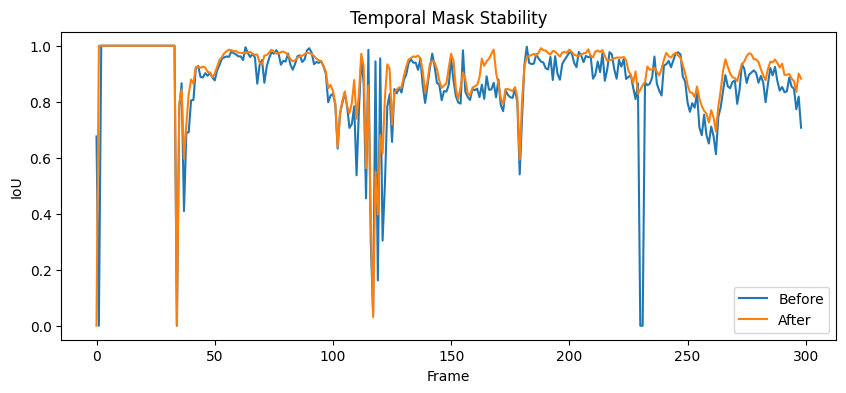

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(ious_before, label="Before")
plt.plot(ious_after, label="After")
plt.xlabel("Frame")
plt.ylabel("IoU")
plt.legend()
plt.title("Temporal Mask Stability")
plt.show()

In [18]:
def overlay_mask(frame, mask, color=(255, 0, 0), alpha=0.5):
    overlay = frame.copy()

    color = np.array(color).reshape(1, 1, 3)
    overlay[mask == 1] = (
        (1 - alpha) * overlay[mask == 1] + alpha * color
    ).astype(np.uint8)

    return overlay

In [19]:
def get_merged(frames, bin_masks, smoothed_masks):
    merged = np.zeros_like(frames)
    for t in range(len(merged)):
        merged[t] = overlay_mask(frames[t], bin_masks[t], alpha = 0.4)
        merged[t] = overlay_mask(merged[t], smoothed_masks[t], color = (0,0,255), alpha = 0.4)
    return merged

In [20]:
merged = get_merged(frames, bin_masks, smoothed_masks)

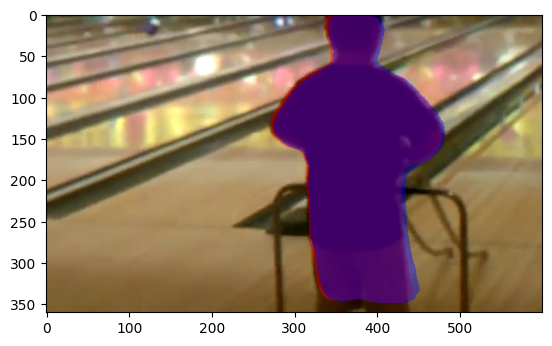

In [21]:
plt.imshow(merged[210])

In [22]:
def update(t):
    img.set_data(merged[t])
    ax.set_title(f"Frame {t}")
    return [img]

In [23]:
def retrun_animation(merged_mask):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis("off")
    img = ax.imshow(merged_mask[0])
    def update(t):
        img.set_data(merged_mask[t])
        ax.set_title(f"Frame {t}")
        return [img]
    anim = animation.FuncAnimation(
        fig,
        update,
        frames=len(frames),
        interval=100,   # миллисекунды
        blit=True
    )
    return anim

In [ ]:
anim = retrun_animation(merged)
HTML(anim.to_jshtml())

### Заметили, что при резких движениях, маска не успевает поменяться с текущим сглаживанием. При колебаниях объекта на одном месте она становится неточной, захватывает область шире, чем нужно. Ещё введём метрику разницы IoS исходного клипа и сглаженного, хотим её уменьшить

In [25]:
def calc_metric(k,both_side, thr_smoothed, frames, bin_masks, prob_maps,ious_before):
    smoothed_probs = temporal_smoothing(prob_maps, k, both_side)
    smoothed_masks = (smoothed_probs > thr_smoothed).astype(np.uint8)
    ious_after = temporal_iou(smoothed_masks)
    diff = (ious_after-ious_before).mean()
    iosm = ious_after.mean()
    title = f"k={k} bs={both_side} thr={thr_smoothed}"
    plt.figure(figsize=(10, 4))
    plt.plot(ious_before, label="Before")
    plt.plot(ious_after, label="After")
    plt.xlabel("Frame")
    plt.ylabel("IoU")
    plt.legend()
    plt.title(title + f",mu_ios={iosm:.2f}, diff = {diff:.2f}")
    plt.show()
    return {"set": title, "diff":diff, "iosm":iosm}

In [ ]:
res = []
for k in [1,2]:
    for both_side in [True, False]:
        for thr in [0.5, 0.6, 0.7]:
            r = calc_metric(k, both_side, thr, frames, bin_masks, prob_maps, ious_before)
            res.append(r)

In [ ]:
# IoU mean BEFORE: 0.865

In [27]:
pd.DataFrame(res).sort_values(by = ["diff", "iosm"], ascending = [True, False])

,set,diff,iosm
5,k=1 bs=False thr=0.7,0.001306,0.866462
11,k=2 bs=False thr=0.7,0.005376,0.870532
2,k=1 bs=True thr=0.7,0.005755,0.870910
4,k=1 bs=False thr=0.6,0.005792,0.870948
3,k=1 bs=False thr=0.5,0.011355,0.876511
10,k=2 bs=False thr=0.6,0.018840,0.883996
1,k=1 bs=True thr=0.6,0.019060,0.884215
8,k=2 bs=True thr=0.7,0.019417,0.884573
7,k=2 bs=True thr=0.6,0.025221,0.890377
9,k=2 bs=False thr=0.5,0.025610,0.890766


### k=2 bs=False thr=0.6 итоговый выбор, так как наименьший diff с исходной маской, по графикам действительно закрывает большие разрывы, и  по среднему IoU лучше, чем без сглаживания (0.884 vs 0.865). Проверим это визуально

In [28]:
smoothed_probs_f = temporal_smoothing(prob_maps, 2, both_side = False)
smoothed_masks_f = (smoothed_probs > 0.6).astype(np.uint8)

In [29]:
merged_f =  get_merged(frames, bin_masks, smoothed_masks_f)

In [ ]:
anim_f = retrun_animation(merged_f)
HTML(anim_f.to_jshtml())